In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import json

# Load Data Pada CSV dan Proses menjadi Data Time Series

In [2]:
#Load data csv dan format data tahun bulan menjadi data frame
df = pd.read_csv('DATASET_PAJAK_PPJ.csv')
df['tahun'] = pd.to_datetime(df['tahun_bulan'])
df.head()

,tahun_bulan,jml_setor,tahun
0,2012-1,1590854848,2012-01-01
1,2012-2,1815655305,2012-02-01
2,2012-3,1755009850,2012-03-01
3,2012-4,1733861503,2012-04-01
4,2012-5,1912141391,2012-05-01


In [3]:
#Buat data tiemseries berdasar key value dari data frame
dts = pd.Series(data=df['jml_setor'].values, index=df['tahun'])
dts.head()
json_data = dts.to_json(date_format='iso')
print(json_data)
with open('./datasets/ppj.json', 'w') as f:
    json.dump(json_data, f) 

{"2012-01-01T00:00:00.000":1590854848,"2012-02-01T00:00:00.000":1815655305,"2012-03-01T00:00:00.000":1755009850,"2012-04-01T00:00:00.000":1733861503,"2012-05-01T00:00:00.000":1912141391,"2012-06-01T00:00:00.000":2018508922,"2012-07-01T00:00:00.000":2274954451,"2012-08-01T00:00:00.000":2269386918,"2012-09-01T00:00:00.000":2227693544,"2012-10-01T00:00:00.000":2312916950,"2012-11-01T00:00:00.000":2520982935,"2012-12-01T00:00:00.000":2167601962,"2013-01-01T00:00:00.000":2552583545,"2013-02-01T00:00:00.000":2395278423,"2013-03-01T00:00:00.000":2214146915,"2013-04-01T00:00:00.000":2506845580,"2013-05-01T00:00:00.000":2456217602,"2013-06-01T00:00:00.000":2517085662,"2013-07-01T00:00:00.000":2664124589,"2013-08-01T00:00:00.000":2705828838,"2013-09-01T00:00:00.000":3037444871,"2013-10-01T00:00:00.000":2774056982,"2013-11-01T00:00:00.000":2593796423,"2013-12-01T00:00:00.000":3406426298,"2014-01-01T00:00:00.000":2991036233,"2014-02-01T00:00:00.000":2935979673,"2014-03-01T00:00:00.000":3356302609,

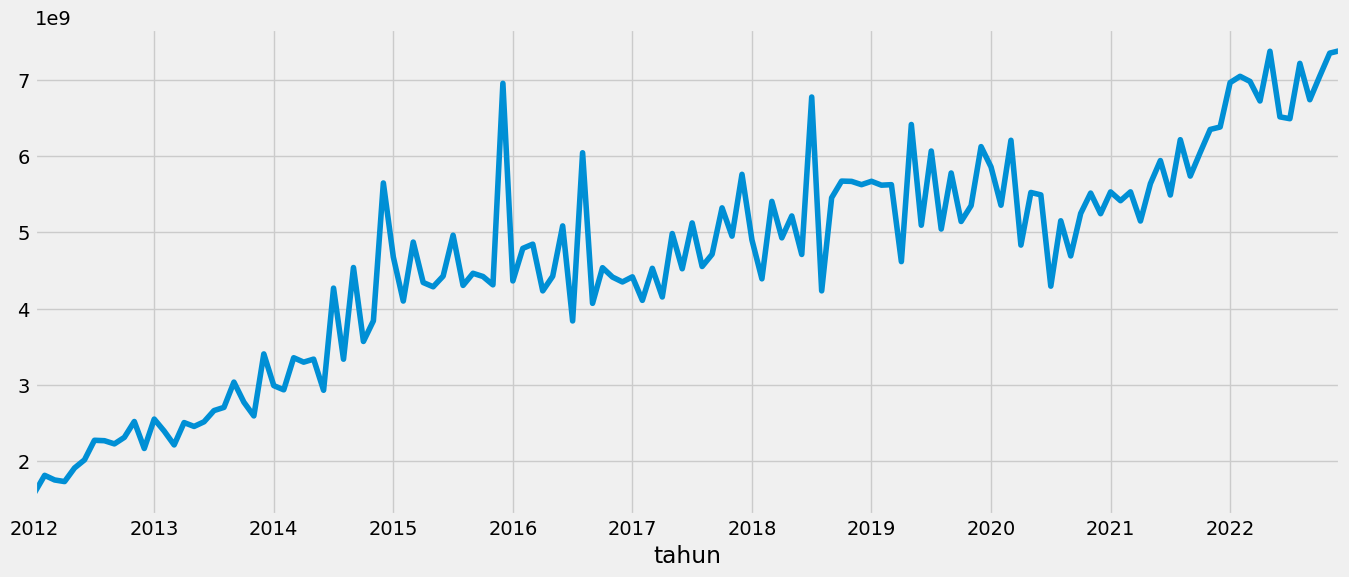

In [4]:
dts = pd.Series(data=df['jml_setor'].values, index=df['tahun'])
dts.plot(figsize=(15, 6))
plt.show()

# Mencari parameter terbaik ARIMA p, d, q

In [5]:
# Tentukan parameter p, d, dan q untuk mengambil nilai antara 0 sampai 5
p = d = q = range(0, 2)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Hasilkan semua kombinasi berbeda dari triplet p, q, dan q musiman
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [5]:
warnings.filterwarnings("ignore")  # specify to ignore warning messages
best_result = [0, 0, 10000000]
p_params = [0, 1, 2, 3]
d_params = [0, 1, 2]
q_params = [0, 1, 2, 3]
P_params = [0, 1, 2, 3]
D_params = [0, 1, 2]
Q_params = [0, 1, 2, 3]
for p in p_params:
    for d in d_params:
        for q in q_params:
            for P in P_params:
                for D in D_params:
                    for Q in Q_params:
                        param = [p, d, q]
                        param_seasonal = [P, D, Q, 12]
                        try:
                            mod = sm.tsa.statespace.SARIMAX(dts, order=param, seasonal_order=param_seasonal)
                            results = mod.fit()
                            if results.aic < best_result[2]:
                                if results.aic > 300:
                                    best_result = [param, param_seasonal, results.aic]
                                    print('Best Result:', best_result)
                        except:
                            continue
print('\nBest Result:', best_result)

Best Result: [[0, 0, 0], [0, 0, 0, 12], 146693.6474274023]
Best Result: [[0, 0, 0], [0, 0, 1, 12], 6213.53482243962]
Best Result: [[0, 0, 0], [0, 0, 3, 12], 6062.382134301493]
Best Result: [[0, 0, 0], [0, 1, 1, 12], 5291.38302188606]
Best Result: [[0, 0, 0], [0, 2, 1, 12], 4768.79186325]
Best Result: [[0, 0, 0], [2, 2, 1, 12], 4765.159802066101]
Best Result: [[0, 0, 3], [0, 2, 1, 12], 4761.221969675799]
Best Result: [[0, 0, 3], [0, 2, 2, 12], 4760.735313096339]
Best Result: [[0, 1, 0], [0, 2, 2, 12], 4754.5653462261125]
Best Result: [[0, 1, 0], [1, 2, 2, 12], 4747.117753356501]
Best Result: [[0, 1, 0], [2, 2, 2, 12], 4743.234306195345]
Best Result: [[0, 1, 0], [3, 2, 1, 12], 4735.530692596134]
Best Result: [[0, 1, 1], [0, 2, 1, 12], 4721.649219280075]
Best Result: [[0, 1, 1], [0, 2, 2, 12], 4717.904689595827]
Best Result: [[0, 1, 2], [0, 2, 1, 12], 4711.85495523222]
Best Result: [[0, 1, 2], [0, 2, 2, 12], 4706.990386784459]
Best Result: [[0, 2, 3], [0, 2, 1, 12], 4695.775918252514]
Bes

In [7]:
 #order=(1, 0, 0),
  #                          seasonal_order=(0, 0, 0, 12),
  #                          enforce_stationarity=False,
    #                        enforce_invertibility=False)

# Plot model diagnostics

In [6]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
mod = sm.tsa.statespace.SARIMAX(dts,order=(3, 2, 3),seasonal_order=(0, 2, 2, 12),
                            enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  132
Model:             SARIMAX(3, 2, 3)x(0, 2, [1, 2], 12)   Log Likelihood               -1713.086
Date:                                 Sun, 02 Apr 2023   AIC                           3444.171
Time:                                         07:18:07   BIC                           3465.381
Sample:                                     01-01-2012   HQIC                          3452.662
                                          - 12-01-2022                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4864      1.087     -1.367      0.171      -3.617       0

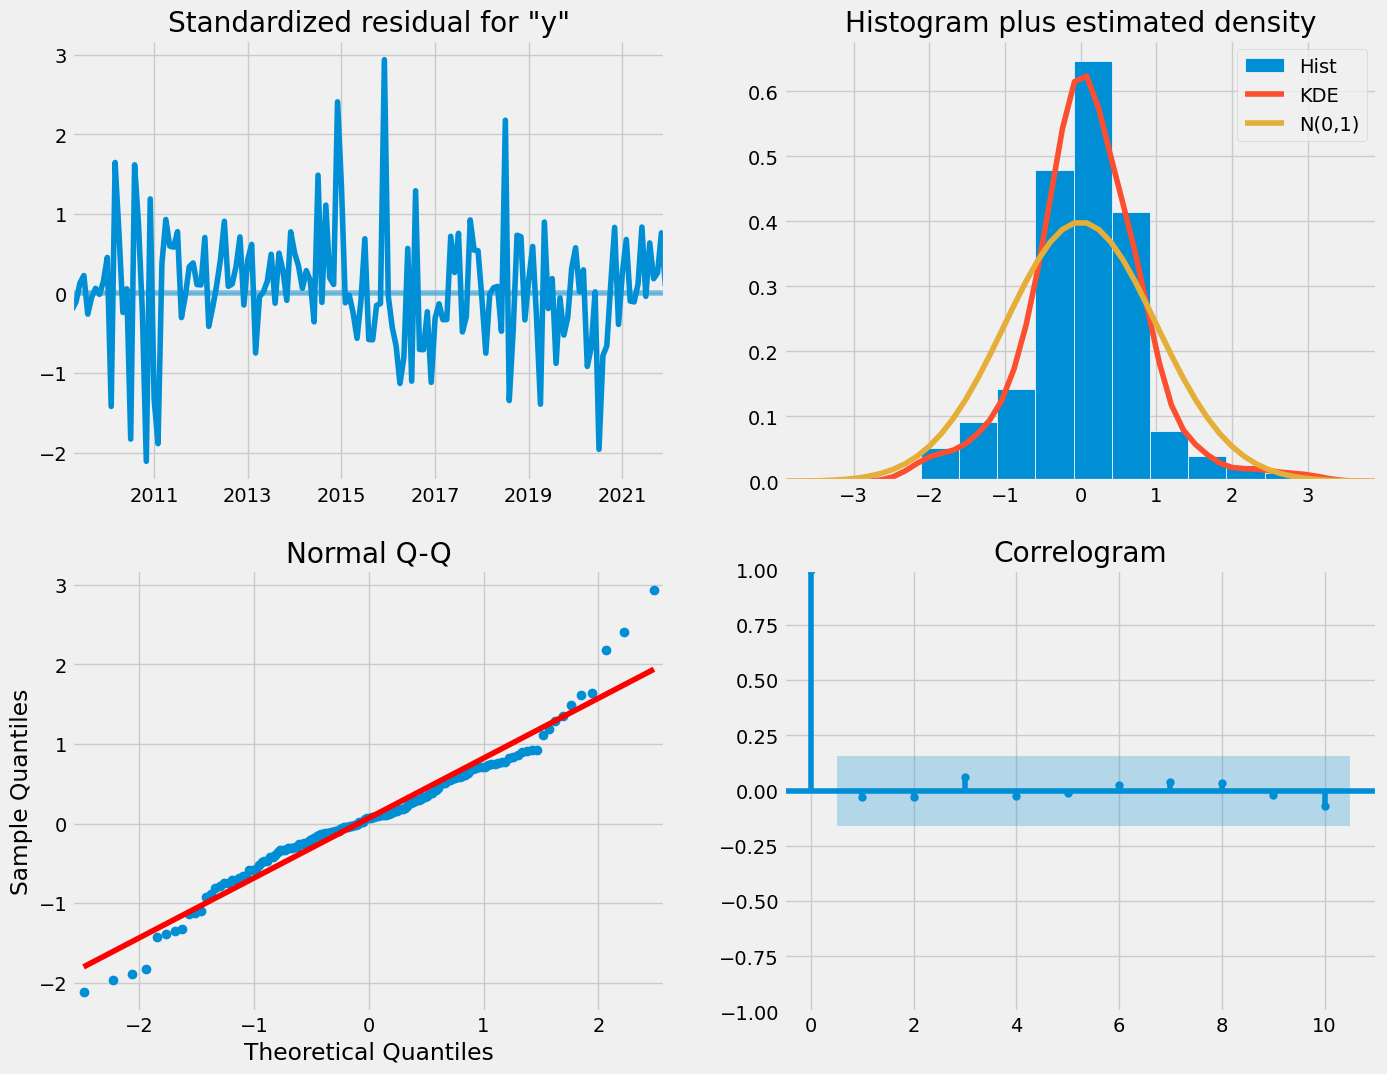

In [9]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

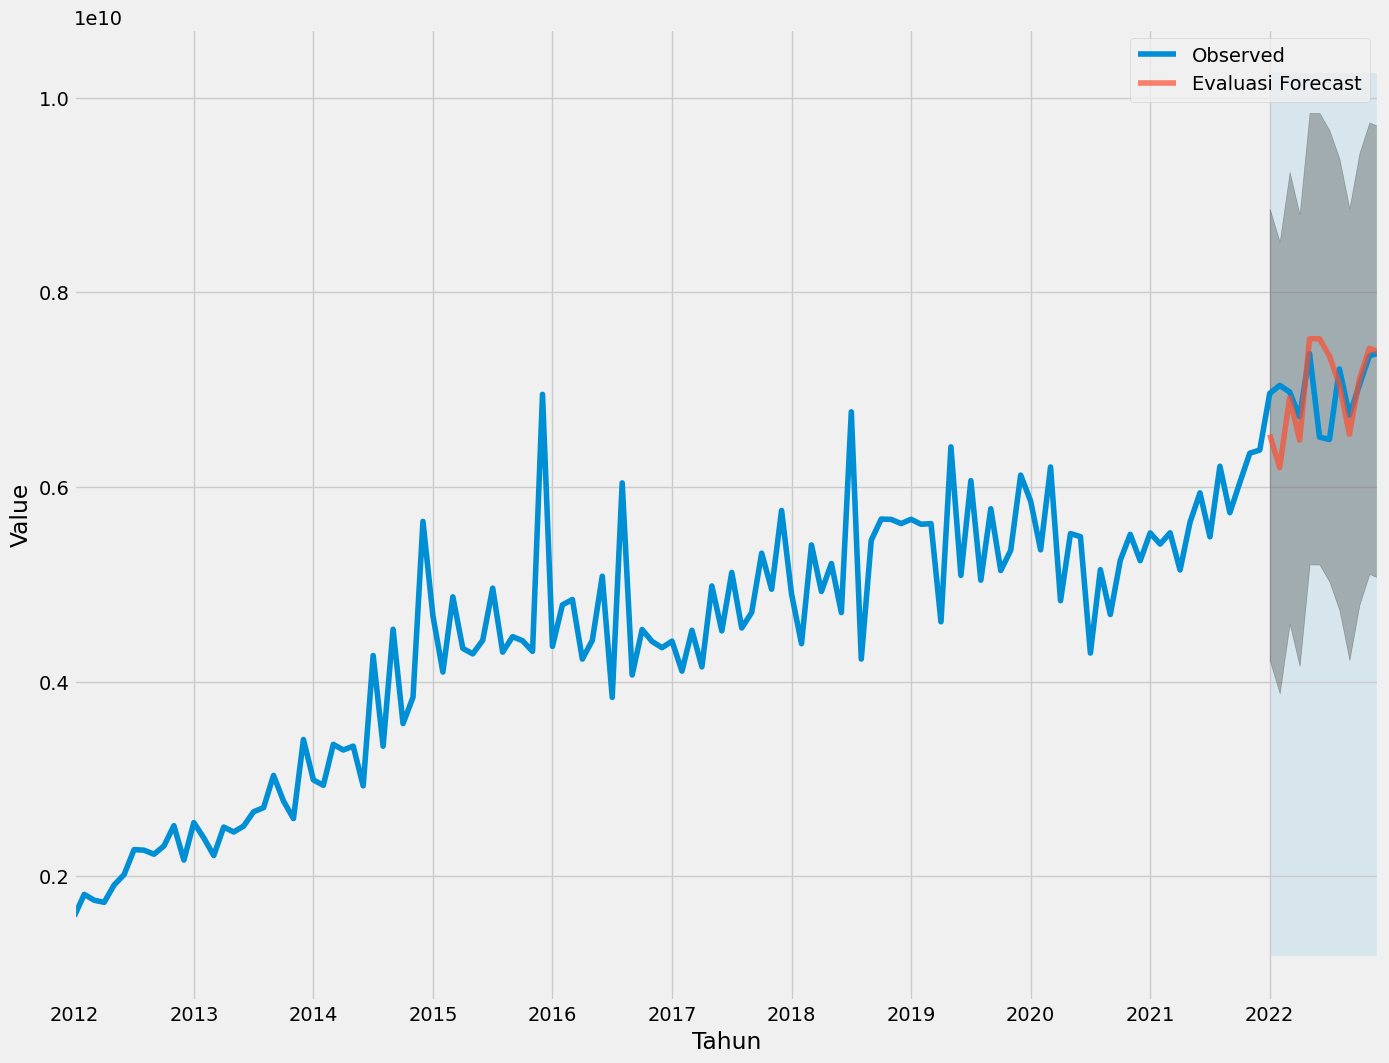

In [8]:
pred = results.get_prediction(start=pd.to_datetime('2022-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = dts['2012':].plot(label='Observed', figsize=(15, 12))
pred.predicted_mean.plot(ax=ax, label='Evaluasi Forecast', alpha=.7)
ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2022-01-01'), dts.index[-1],alpha=.1, zorder=-1)
ax.set_xlabel('Tahun')
ax.set_ylabel('Value')
plt.legend()
plt.show()

In [11]:
df_test = df[df.tahun.between('2022-01', '2022-12')]
dts_test = pd.Series(data=df_test['jml_setor'].values, index=df_test['tahun'])
y_test, pred_ahead = np.array(dts_test), np.array(pred.predicted_mean)
list_ape = []
for index, elem in np.ndenumerate(pred_ahead):
    ape = np.abs(elem-y_test[index]) / y_test[index]
    list_ape.append(ape*100)
mape = np.mean(list_ape)
print(y_test)
print(pred.predicted_mean.to_json(date_format='iso'))
print(list_ape)
print(mape)

[6960955160 7043573513 6976085674 6720276243 7371742183 6512179766
 6488011000 7213056000 6736494000 7045946000 7347055000 7379277000]
{"2022-01-01T00:00:00.000":6538649951.7147483826,"2022-02-01T00:00:00.000":6199884505.8087024689,"2022-03-01T00:00:00.000":6915219539.7555942535,"2022-04-01T00:00:00.000":6481262185.9909276962,"2022-05-01T00:00:00.000":7523327485.3028774261,"2022-06-01T00:00:00.000":7522297179.639125824,"2022-07-01T00:00:00.000":7343942541.8765144348,"2022-08-01T00:00:00.000":7051826655.7981729507,"2022-09-01T00:00:00.000":6542044129.5846700668,"2022-10-01T00:00:00.000":7108176431.5707702637,"2022-11-01T00:00:00.000":7425025285.0129032135,"2022-12-01T00:00:00.000":7382687397.7518939972}
[6.066770990164684, 11.978138733614967, 0.8724969429669558, 3.55661059704257, 2.0563022761762992, 15.511202852736572, 13.192510645812938, 2.2352432062336276, 2.886514415589622, 0.8832090335459606, 1.0612454243625944, 0.04621587930489664]
5.028871749795974


# Prediksi data selama 2 tahun

In [13]:
# prediksi 24 langkah ke depan di masa mendatang
pred_uc = results.get_forecast(steps=24, dynamic=False)
# Dapatkan interval
pred_ci = pred_uc.conf_int()


json_data = pred_uc.predicted_mean.to_json(date_format='iso')
print(json_data)
with open('./datasets/ppj_predicted.json', 'w') as f:
    json.dump(json_data, f) 

{"2022-01-01T00:00:00.000":6158563159.0981531143,"2022-02-01T00:00:00.000":5910434385.8590831757,"2022-03-01T00:00:00.000":6433051629.8822231293,"2022-04-01T00:00:00.000":5919704769.518611908,"2022-05-01T00:00:00.000":6338633234.8159036636,"2022-06-01T00:00:00.000":6167809061.9453172684,"2022-07-01T00:00:00.000":6285691185.2607288361,"2022-08-01T00:00:00.000":6350271594.3925113678,"2022-09-01T00:00:00.000":6285219653.7802410126,"2022-10-01T00:00:00.000":6340499085.6330709457,"2022-11-01T00:00:00.000":6350280754.9232578278,"2022-12-01T00:00:00.000":6764350664.2726192474,"2023-01-01T00:00:00.000":6431048910.5082654953,"2023-02-01T00:00:00.000":6227513418.7945785522,"2023-03-01T00:00:00.000":6732468244.9529523849,"2023-04-01T00:00:00.000":6226117079.7738742828,"2023-05-01T00:00:00.000":6642274704.0974340439,"2023-06-01T00:00:00.000":6472548000.3845500946,"2023-07-01T00:00:00.000":6589995440.308339119,"2023-08-01T00:00:00.000":6654748017.9695301056,"2023-09-01T00:00:00.000":6589627885.1900

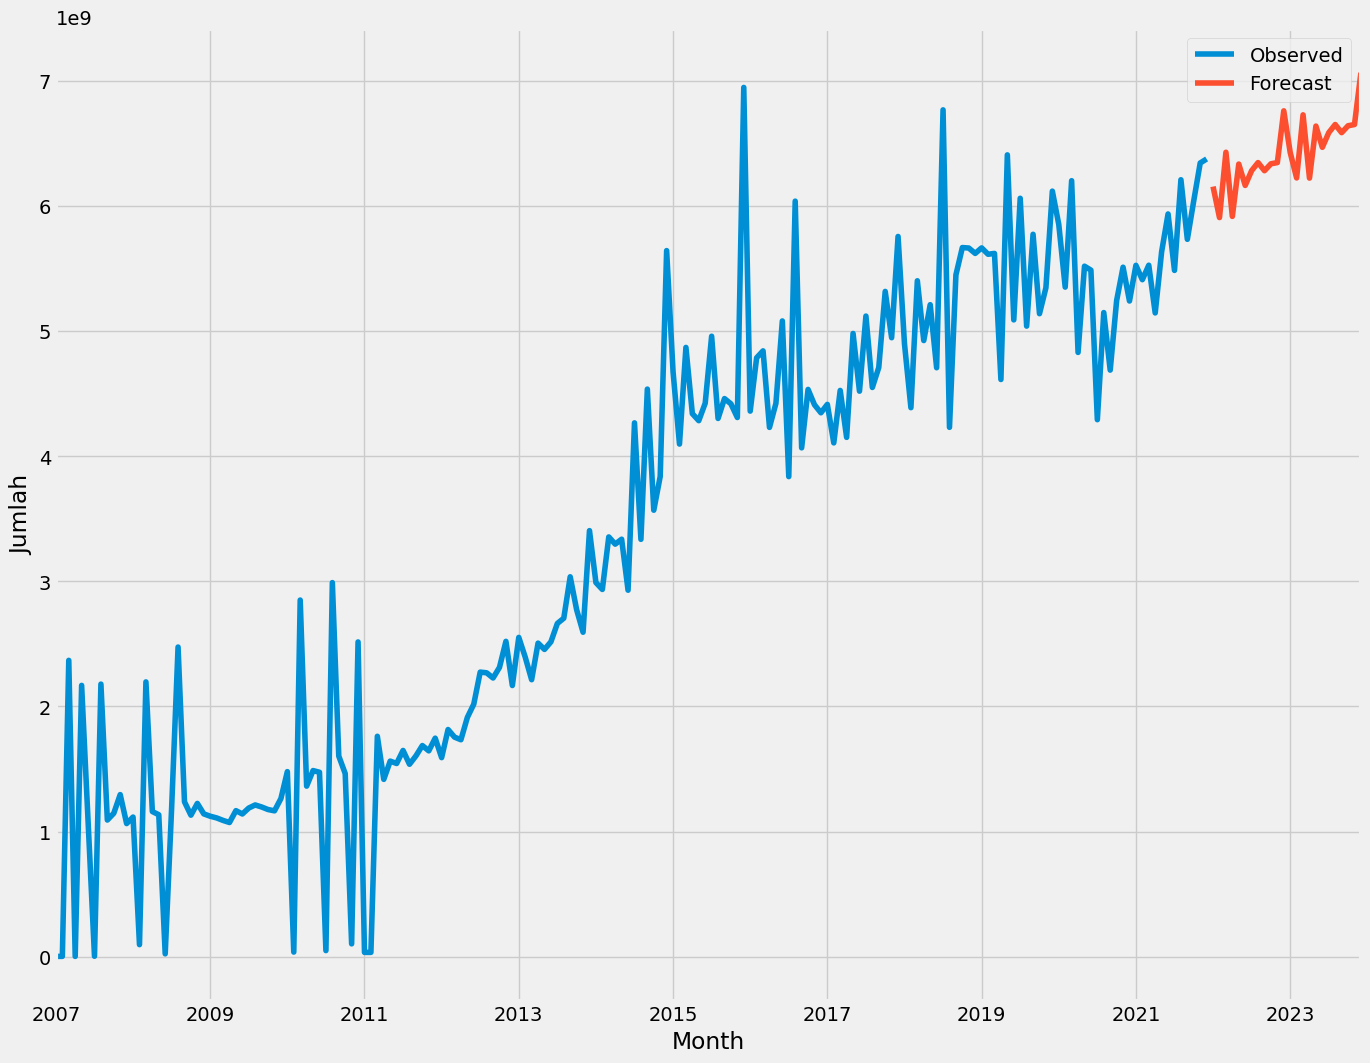

In [14]:
ax = dts.plot(label='Observed', figsize=(15, 12))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.set_xlabel('Month')
ax.set_ylabel('Jumlah')
plt.legend()
plt.show()